In [1]:
import glob
import os
import sys

from cartopy.crs import NorthPolarStereo
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import RegularGridInterpolator


In [2]:
def read_rgps(filename,land_fill=1e10,nodata_fill=np.nan):
    # based on https://github.com/nhutter/lkf_tools/blob/a67e1266b1d17aeec4a839ad190541ba4ae1ee45/lkf_detection.py#L902
    # RGPS product header 
    dxg=0. #Size of x cell in product
    dyg=0. #Size of y cell in product
    xg0=0. #Map location of x lower left
    yg0=0. #Map location of y lower left
    xg1=0. #Map location of x higher right
    yg1=0. #Map location of y higher right
    nxcell=0 #x cells dimensional array
    nycell=0 #y cells dimensional array
    
    with open(filename,'rt', errors='replace') as rgps_file:
        dxg,dyg,xg0,yg0,xg1,yg1 = rgps_file.readline().strip().split()
        nxcell,nycell = rgps_file.readline().strip().split()
        data = np.fromfile(rgps_file, np.float32).reshape(int(nycell), int(nxcell))

    if sys.byteorder == 'little': data.byteswap(True)

    data[data==1e10] = land_fill
    data[data==1e20] = nodata_fill

    return data, float(xg0), float(xg1), float(yg0), float(yg1), int(nxcell), int(nycell)

In [3]:
# read data from two RGPS files
idir = '/data1/antonk/tmp/w0607'
div_files = sorted(glob.glob(f'{idir}/*DIV'))
shr_files = sorted(glob.glob(f'{idir}/*SHR'))
rgps_div, xg0, xg1, yg0, yg1, nxcell, nycell = read_rgps(div_files[0])
rgps_shr, xg0, xg1, yg0, yg1, nxcell, nycell = read_rgps(shr_files[0])

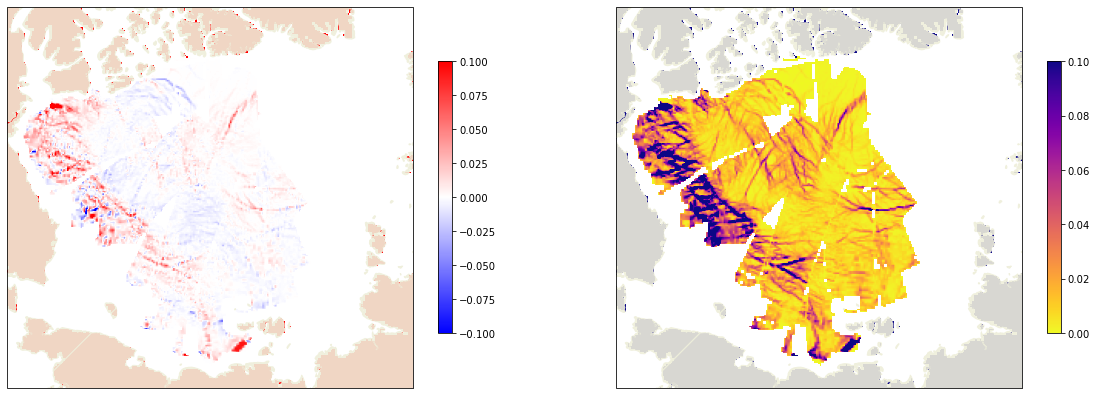

In [4]:
# convert coordinates to NorthPolarStereo projection
x = np.linspace(xg0,xg1,nxcell+1)*1000 - 1000*np.abs(xg0-xg1)/nycell
y = np.linspace(yg0,yg1,nycell+1)*1000 - 2000*np.abs(yg0-yg1)/nycell
x_min, x_max = x.min(), x.max()
y_min, y_max = y.max(), y.min()
srs_rgps = NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

fig, axs = plt.subplots(1,2,subplot_kw={'projection': srs_rgps}, figsize=(20,10))
imsh0 = axs[0].imshow(rgps_div, extent=[x_min, x_max, y_min, y_max], clim=[-0.1, 0.1], cmap='bwr', zorder=0)
plt.colorbar(imsh0, ax=axs[0], shrink=0.5)
imsh1 = axs[1].imshow(rgps_shr, extent=[x_min, x_max, y_min, y_max], clim=[0, 0.1], cmap='plasma_r', zorder=0)
plt.colorbar(imsh1, ax=axs[1], shrink=0.5)
for ax in axs:
    ax.add_feature(cfeature.LAND, zorder=1, alpha=0.9)

plt.show()